## Search for dividend growth companies

### Update Oct 2023

We will begin our search with in Netherlands, which currently seems to be a booming economy and has relatively low dividend tax 15% (https://taxsummaries.pwc.com/netherlands/corporate/withholding-taxes).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import datetime
import pytz


In [2]:
# dfs = pd.read_html("https://www.dividendmax.com/stock-exchange-listings/netherlands/euronext-amsterdam")
df = pd.read_csv("amsterdam_exch_2023-10-14.csv", sep=";")
def flatten(l):
    return [item for sublist in l for item in sublist]
pd.DataFrame(flatten(df["Market"].str.split(",").to_list()))[0].unique()

array(['Euronext Amsterdam', 'Euronext Paris', ' Amsterdam',
       'Euronext Brussels', ' Brussels', ' Paris'], dtype=object)

In [6]:
df.iloc[0]["Symbol"]

'AALB'

In [26]:
symbol = "QWABS"
company = yf.Ticker(symbol + ".PA")
if len(company.dividends):
    div_df = pd.DataFrame(company.dividends).reset_index()
    tz = pytz.timezone(str(div_df["Date"].iloc[0].tz))
    div_df_10yrs = div_df[div_df["Date"] >= datetime.datetime(2013, 1, 1, tzinfo=tz)]
    div_df_10yrs_grouped = div_df_10yrs.groupby(div_df_10yrs["Date"].dt.year).sum(numeric_only=True).reset_index()
    div_df_10yrs_grouped["pct_change"] = div_df_10yrs_grouped["Dividends"].pct_change(periods=1)
    div_df_10yrs_grouped["pct_change_10"] = div_df_10yrs_grouped["Dividends"].pct_change(periods=10)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
pd.DataFrame(company.dividends).reset_index()
if len(company.dividends):
    print("hello")

In [32]:
year_10 = 10 if len(div_df_10yrs_grouped) > 10 else len(div_df_10yrs_grouped) - 1
year_5 = 5 if len(div_df_10yrs_grouped) > 5 else len(div_df_10yrs_grouped) - 1
res = {
    "growth_10": div_df_10yrs_grouped["Dividends"].pct_change(periods=year_10).iloc[-1],
    "growth_yy_10": ((div_df_10yrs_grouped["Dividends"].shift(-year_10) / div_df_10yrs_grouped["Dividends"]) ** (1 / year_10) - 1).dropna().iloc[-1],
    "growth_yy_5": ((div_df_10yrs_grouped["Dividends"].shift(-year_5) / div_df_10yrs_grouped["Dividends"]) ** (1 / year_5) - 1).dropna().iloc[-1],
    "growth_yy_3": ((div_df_10yrs_grouped["Dividends"].shift(-3) / div_df_10yrs_grouped["Dividends"]) ** (1 / 3) - 1).dropna().iloc[-1],
    "growth_yy_1": ((div_df_10yrs_grouped["Dividends"].shift(-1) / div_df_10yrs_grouped["Dividends"]) ** (1 / 1) - 1).dropna().iloc[-1],
}
res

{'growth_10': 0.6666666666666667,
 'growth_yy_10': 0.05840007284126747,
 'growth_yy_5': 0.008548252303932413,
 'growth_yy_3': 0.06265856918261115,
 'growth_yy_1': 0.14285714285714302}

In [48]:
# pd.Series([div_df_10yrs_grouped["Date"].min() + i for i in range(len(div_dfo_10yrs_grouped))]).diff(div_df_10yrs_grouped["Date"])
# div_df_10yrs_grouped["Date"].min(), div_df_10yrs_grouped["Date"].max()

,Date,Dividends,pct_change,pct_change_10
9,2023,1.20,0.142857,NaN
8,2022,1.05,-0.045455,NaN
7,2020,1.10,0.100000,NaN
6,2019,1.00,0.428571,NaN
5,2018,0.70,-0.391304,NaN
4,2017,1.15,0.150000,NaN
3,2016,1.00,-0.090909,NaN
2,2015,1.10,0.100000,NaN
1,2014,1.00,0.388889,NaN
0,2013,0.72,NaN,NaN


In [145]:
q_low = div_df_10yrs_grouped["pct_change"].abs().quantile(0.1)
q_high = div_df_10yrs_grouped["pct_change"].quantile(0.9)
div_df_10yrs_grouped[(div_df_10yrs_grouped["pct_change"].abs() > q_low) & (div_df_10yrs_grouped["pct_change"].abs() < q_high)]["pct_change"].mean()

0.36161003606346187

<Axes: xlabel='Date'>

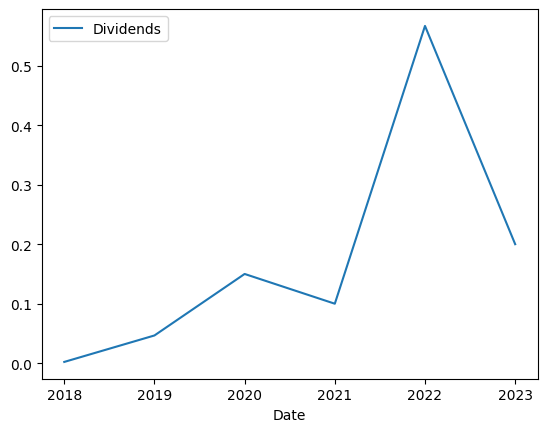

In [10]:
div_df_10yrs_grouped.plot(x="Date", y="Dividends")

In [141]:
div_df_10yrs_grouped["Dividends"].pct_change(periods=10)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    2.171429
Name: Dividends, dtype: float64

In [25]:
((div_df_10yrs_grouped["Dividends"].shift(-5) / div_df_10yrs_grouped["Dividends"]) ** (1 / 5) - 1)
pd.concat([div_df_10yrs_grouped["Dividends"].shift(-5), div_df_10yrs_grouped["Dividends"]], axis=1)

,Dividends,Dividends
0,0.2,0.002222
1,NaN,0.046667
2,NaN,0.150000
3,NaN,0.100000
4,NaN,0.566667
5,NaN,0.200000


In [38]:
div_df_10yrs_grouped[(np.abs(stats.zscore(div_df_10yrs_grouped["Dividends"])) > 2)].to_dict(orient="records")


[{'Date': 2020,
  'Dividends': 1.6,
  'pct_change': 1.1333333333333333,
  'pct_change_10': nan}]

### Search for low debt companies

In [4]:
balance = company.balance_sheet
income = company.income_stmt
cash = company.cash_flow
latest = balance.columns.sort_values()[-1]

In [59]:
x.loc["Diluted Average Shares"]

2019-12-31    24657249.0
2020-12-31    29585516.0
2021-12-31    29653872.0
2022-12-31    29617746.0
Name: Diluted Average Shares, dtype: object

In [79]:
qlow = income.loc["Net Income"].quantile(0.02)
qhigh = income.loc["Net Income"].quantile(0.98)

income.loc["Net Income"][(income.loc["Net Income"] > qlow) & (income.loc["Net Income"] < qhigh)].mean()

359063000.0

In [101]:
x = income.loc["Net Income"] / income.loc["Total Revenue"]

qlow = x.quantile(0.01)
qhigh = x.quantile(0.99)
x[(x > qlow) & (x < qhigh)].mean()

0.04322007980010193

In [102]:
x[(x > qlow) & (x < qhigh)]

2022-12-31    0.056227
2019-12-31    0.030213
dtype: object

In [104]:
x.sort_values()

2020-12-31     0.00598
2019-12-31    0.030213
2022-12-31    0.056227
2021-12-31    0.058757
dtype: object

In [107]:
any(income.loc["Total Revenue"] == 0)

False

In [109]:
div_df_10yrs_grouped["Dividends"].pct_change(periods=10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Dividends, dtype: float64

In [16]:
((income.sort_index(axis=1).loc["Diluted Average Shares"].shift(-2) / income.sort_index(axis=1).loc["Diluted Average Shares"]) ** (1 / 3) - 1).dropna().iloc[-1]

0.00036299635558334487

In [18]:
pd.concat([income.sort_index(axis=1).loc["Diluted Average Shares"].shift(-2), income.sort_index(axis=1).loc["Diluted Average Shares"] ], axis=1)

,Diluted Average Shares,Diluted Average Shares
2019-12-31,29653872.0,24657249.0
2020-12-31,29617746.0,29585516.0
2021-12-31,None,29653872.0
2022-12-31,None,29617746.0


In [25]:

all_years = pd.Series(range(div_df_10yrs_grouped["Date"].min(), div_df_10yrs_grouped["Date"].max() + 1))
missing_dividend_years = all_years[all_years.isin(div_df_10yrs_grouped["Date"]) == False]

missing_dividend_years.count()

1

In [54]:
xx = income.sort_index(axis=1)
def get_growth_per_year(series, year):
    x = ((series.shift(-year) / series) ** (1 / year)) - 1
    return x.dropna().iloc[-1]

get_growth_per_year(xx.loc["Diluted Average Shares"], -3) if "Diluted Average Shares" in income.index and len(income.loc["Diluted Average Shares"].dropna()) == 4 else np.NaN

0.0630061924527705

In [53]:
income.loc["Diluted Average Shares"]

2022-12-31    29617746.0
2021-12-31    29653872.0
2020-12-31    29585516.0
2019-12-31    24657249.0
Name: Diluted Average Shares, dtype: object

In [33]:
res

{'growth_10': 0.6666666666666667,
 'growth_yy_10': 0.05840007284126747,
 'growth_yy_5': 0.008548252303932413,
 'growth_yy_3': 0.06265856918261115,
 'growth_yy_1': 0.14285714285714302}

In [62]:
div_df

,Date,Dividends
0,2004-09-27 00:00:00-04:00,0.075
1,2005-07-19 00:00:00-04:00,0.150
2,2006-07-18 00:00:00-04:00,0.300
3,2007-07-18 00:00:00-04:00,0.480
4,2008-07-14 00:00:00-04:00,0.580


In [66]:
div_df.style.applymap(lambda x: 'color: red' if x is int and x < 1 else 'color: white')

,Date,Dividends
0,2004-09-27 00:00:00-04:00,0.075000
1,2005-07-19 00:00:00-04:00,0.150000
2,2006-07-18 00:00:00-04:00,0.300000
3,2007-07-18 00:00:00-04:00,0.480000
4,2008-07-14 00:00:00-04:00,0.580000


In [7]:
div_df["Dividends"].mean() / income.loc["Net Income"].mean()

1.6598882791062331e-09

In [8]:
div_df_10yrs_grouped["Dividends"]

,Date,Dividends,pct_change,pct_change_10
0,2013,0.35,NaN,NaN
1,2014,0.41,0.171429,NaN
2,2015,0.46,0.121951,NaN
3,2016,0.52,0.130435,NaN
4,2017,0.58,0.115385,NaN
5,2018,0.65,0.120690,NaN
6,2019,0.75,0.153846,NaN
7,2020,1.60,1.133333,NaN
8,2021,0.60,-0.625000,NaN
9,2022,0.64,0.066667,NaN


In [11]:
div_df_10yrs_grouped["Dividends"].mean() / income.loc["Diluted EPS"].mean()

0.3031620553359684